In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

In [2]:
# Function to create sequences
def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(window_size, len(data)):
        sequences.append(data[i-window_size:i])
        labels.append(data[i])
    return np.array(sequences), np.array(labels)

In [3]:
# Step 1: Load Data
alinma_train_data = pd.read_csv('1150-Historical-Data-train.csv')
alrajhi_train_data = pd.read_csv('1120-Historical-Data-train.csv')
sspc_train_data = pd.read_csv('1320-Historical-Data-train.csv')
sabic_train_data = pd.read_csv('2010-Historical-Data-train.csv')
stc_train_data = pd.read_csv('7010-Historical-Data-train.csv')

In [4]:
# Step 2: Preprocess Data
for df in [alinma_train_data, alrajhi_train_data, sspc_train_data, sabic_train_data, stc_train_data]:
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)

In [5]:
# Use only the 'Close' column for simplicity
close_prices_alinma = alinma_train_data['Price'].values.reshape(-1, 1)
close_prices_alrajhi = alrajhi_train_data['Price'].values.reshape(-1, 1)
close_prices_sspc = sspc_train_data['Price'].values.reshape(-1, 1)
close_prices_sabic = sabic_train_data['Price'].values.reshape(-1, 1)
close_prices_stc = stc_train_data['Price'].values.reshape(-1, 1)

In [6]:
alinma_train_data.describe()

,Date,Price,Open,High,Low
count,4002,4002.000000,4002.000000,4002.000000,4002.000000
mean,2016-06-14 04:55:24.737630976,13.117079,13.115412,13.248446,12.987804
min,2008-06-04 00:00:00,5.310000,5.280000,5.460000,5.250000
25%,2012-06-06 18:00:00,7.920000,7.920000,7.980000,7.860000
50%,2016-06-08 12:00:00,11.035000,11.025000,11.130000,10.935000
75%,2020-06-17 18:00:00,14.500000,14.517500,14.590000,14.400000
max,2024-06-30 00:00:00,35.960000,35.960000,36.000000,35.480000
std,NaN,7.415345,7.411220,7.506954,7.324761


In [7]:
alrajhi_train_data.describe()

,Date,Price,Open,High,Low
count,6430,6430.000000,6430.000000,6430.000000,6430.000000
mean,2011-10-12 22:44:45.163297024,32.801776,32.797278,33.147062,32.462911
min,2000-01-03 00:00:00,6.150000,6.150000,6.150000,6.150000
25%,2005-05-09 06:00:00,20.910000,20.920000,21.230000,20.620000
50%,2011-07-28 12:00:00,27.560000,27.540000,27.750000,27.280000
75%,2018-01-10 18:00:00,38.470000,38.445000,38.750000,37.862500
max,2024-06-30 00:00:00,114.750000,114.880000,117.400000,112.200000
std,NaN,22.503168,22.520860,22.788747,22.240304


In [8]:
sspc_train_data.describe()

,Date,Price,Open,High,Low
count,3707,3707.000000,3707.000000,3707.000000,3707.000000
mean,2017-01-15 11:12:48.168330240,25.643798,25.667958,26.032074,25.329692
min,2009-08-05 00:00:00,12.700000,12.050000,13.000000,12.050000
25%,2013-04-27 12:00:00,19.700000,19.700000,20.000000,19.500000
50%,2017-01-16 00:00:00,24.500000,24.500000,24.780000,24.200000
75%,2020-10-07 12:00:00,29.125000,29.200000,29.500000,28.800000
max,2024-06-30 00:00:00,89.100000,92.400000,94.000000,84.400000
std,NaN,9.241954,9.258179,9.492652,9.006431


In [9]:
sabic_train_data.describe()

,Date,Price,Open,High,Low
count,5831,5831.000000,5831.000000,5831.000000,5831.000000
mean,2012-11-19 01:10:52.581032448,94.269033,94.250268,95.332298,93.254227
min,2001-12-02 00:00:00,14.050000,0.000000,14.570000,14.050000
25%,2006-12-11 12:00:00,80.500000,80.500000,81.500000,79.700000
50%,2012-10-14 00:00:00,94.000000,94.000000,94.600000,93.250000
75%,2018-08-15 12:00:00,113.000000,112.960000,114.400000,111.500000
max,2024-06-30 00:00:00,249.100000,247.330000,252.270000,245.370000
std,NaN,40.617821,40.573670,41.188725,40.004800


In [10]:
stc_train_data.describe()

,Date,Price,Open,High,Low
count,5506,5506.000000,5506.000000,5506.000000,5506.000000
mean,2013-06-30 23:34:37.878678016,30.657247,30.647347,30.967588,30.335087
min,2003-01-26 00:00:00,11.550000,11.410000,11.890000,11.400000
25%,2007-12-03 06:00:00,21.900000,21.900000,22.100000,21.400000
50%,2013-06-04 12:00:00,28.110000,28.100000,28.360000,27.860000
75%,2018-12-17 18:00:00,39.480000,39.515000,39.760000,39.175000
max,2024-06-30 00:00:00,74.400000,77.400000,77.400000,72.600000
std,NaN,11.875203,11.874113,12.050857,11.702548


In [11]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_alinma = scaler.fit_transform(close_prices_alinma)
scaled_close_alrajhi = scaler.fit_transform(close_prices_alrajhi)
scaled_close_sspc = scaler.fit_transform(close_prices_sspc)
scaled_close_sabic = scaler.fit_transform(close_prices_sabic)
scaled_close_stc = scaler.fit_transform(close_prices_stc)

In [12]:
# Step 3: Create Sequences with a window of 3
window_size = 3
X1, y1 = create_sequences(scaled_close_alinma, window_size)
X2, y2 = create_sequences(scaled_close_alrajhi, window_size)
X3, y3 = create_sequences(scaled_close_sspc, window_size)
X4, y4 = create_sequences(scaled_close_sabic, window_size)
X5, y5 = create_sequences(scaled_close_stc, window_size)

In [13]:
# Split the data into training and testing sets
split1 = int(0.8 * len(X1))
X_train1, X_test1 = X1[:split1], X1[split1:]
y_train1, y_test1 = y1[:split1], y1[split1:]

split2 = int(0.8 * len(X2))
X_train2, X_test2 = X2[:split2], X2[split2:]
y_train2, y_test2 = y2[:split2], y2[split2:]

split3 = int(0.8 * len(X3))
X_train3, X_test3 = X3[:split3], X3[split3:]
y_train3, y_test3 = y3[:split3], y3[split3:]

split4 = int(0.8 * len(X4))
X_train4, X_test4 = X4[:split4], X4[split4:]
y_train4, y_test4 = y4[:split4], y4[split4:]

split5 = int(0.8 * len(X5))
X_train5, X_test5 = X5[:split5], X5[split5:]
y_train5, y_test5 = y5[:split5], y5[split5:]

In [14]:
# Reshape X to be 3D [samples, time steps, features]
X_train1 = X_train1.reshape((X_train1.shape[0], X_train1.shape[1], 1))
X_test1 = X_test1.reshape((X_test1.shape[0], X_test1.shape[1], 1))

X_train2 = X_train2.reshape((X_train2.shape[0], X_train2.shape[1], 1))
X_test2 = X_test2.reshape((X_test2.shape[0], X_test2.shape[1], 1))

X_train3 = X_train3.reshape((X_train3.shape[0], X_train3.shape[1], 1))
X_test3 = X_test3.reshape((X_test3.shape[0], X_test3.shape[1], 1))

X_train4 = X_train4.reshape((X_train4.shape[0], X_train4.shape[1], 1))
X_test4 = X_test4.reshape((X_test4.shape[0], X_test4.shape[1], 1))

X_train5 = X_train5.reshape((X_train5.shape[0], X_train5.shape[1], 1))
X_test5 = X_test5.reshape((X_test5.shape[0], X_test5.shape[1], 1))

In [15]:
# Function to build the LSTM model
def build_model(optimizer):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# <span style="color:#E888BB; font-size: 1%;">1 | Alinma Bank Model </span>
<div style="padding: 35px;color:white;margin:10;font-size:170%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQbDkpIvhGvyOIyULyNV_W4HOKobW4xvaWkZA&s)"><b><span style='color:black'>1 | Alinma Bank Model </span></b> </div>


In [16]:
# Experiment with different optimizers, epoch numbers, and batch sizes
optimizers = ['adam', 'adamax', 'nadam', 'rmsprop']
epoch_numbers = [20, 50, 100]
batch_sizes = [32, 64, 128, 256]
results = []
best_rmse = float('inf')
best_models = {optimizer: None for optimizer in optimizers}
best_params = {optimizer: (float('inf'), None, None) for optimizer in optimizers}

In [17]:
for optimizer in optimizers:
    for epochs in epoch_numbers:
        for batch_size in batch_sizes:
            model = build_model(optimizer)
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            history = model.fit(X_train1, y_train1, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping])
            
            # Evaluate the Model
            y_pred = model.predict(X_test1)
            y_test_inv = scaler.inverse_transform(y_test1.reshape(-1, 1))
            y_pred_inv = scaler.inverse_transform(y_pred)
            
            mse = mean_squared_error(y_test_inv, y_pred_inv)
            mae = mean_absolute_error(y_test_inv, y_pred_inv)
            rmse = np.sqrt(mse)
            
            results.append((optimizer, epochs, batch_size, mse, mae, rmse))
            
            # Save the best model for each optimizer
            if optimizer not in best_params or rmse < best_params[optimizer][0]:
                best_params[optimizer] = (rmse, epochs, batch_size)
                best_models[optimizer] = model
                model.save(f'alinma_{optimizer}_best_model.h5')

Epoch 1/20
80/80 [==============================] - 11s 41ms/step - loss: 0.0032 - val_loss: 2.7830e-04
Epoch 2/20
80/80 [==============================] - 1s 11ms/step - loss: 6.4682e-05 - val_loss: 9.7792e-05
Epoch 3/20
80/80 [==============================] - 1s 19ms/step - loss: 6.0106e-05 - val_loss: 9.6586e-05
Epoch 4/20
80/80 [==============================] - 1s 11ms/step - loss: 5.9312e-05 - val_loss: 1.1826e-04
Epoch 5/20
80/80 [==============================] - 1s 13ms/step - loss: 5.9095e-05 - val_loss: 9.0265e-05
Epoch 6/20
80/80 [==============================] - 2s 19ms/step - loss: 5.8523e-05 - val_loss: 9.0840e-05
Epoch 7/20
80/80 [==============================] - 1s 12ms/step - loss: 6.0415e-05 - val_loss: 9.3229e-05
Epoch 8/20
80/80 [==============================] - 1s 11ms/step - loss: 5.8714e-05 - val_loss: 9.0519e-05
Epoch 9/20
80/80 [==============================] - 1s 14ms/step - loss: 6.2064e-05 - val_loss: 8.9793e-05
Epoch 10/20
80/80 [=====================

In [18]:
# Display the results
for result in results:
    print(f'Optimizer: {result[0]}, Epochs: {result[1]}, Batch Size: {result[2]}, MSE: {result[3]}, MAE: {result[4]}, RMSE: {result[5]}')

Optimizer: adam, Epochs: 20, Batch Size: 32, MSE: 2.1679540339258985, MAE: 1.0692738481462514, RMSE: 1.4723973763647837
Optimizer: adam, Epochs: 20, Batch Size: 64, MSE: 2.4798338496296135, MAE: 1.16738197359129, RMSE: 1.574748821123424
Optimizer: adam, Epochs: 20, Batch Size: 128, MSE: 15.76591481455488, MAE: 3.213219225290893, RMSE: 3.9706315385030226
Optimizer: adam, Epochs: 20, Batch Size: 256, MSE: 18.96531404306549, MAE: 3.550873254724966, RMSE: 4.354918373869422
Optimizer: adam, Epochs: 50, Batch Size: 32, MSE: 2.9501011276859543, MAE: 1.305336143550278, RMSE: 1.7175858428870314
Optimizer: adam, Epochs: 50, Batch Size: 64, MSE: 3.2472286042785856, MAE: 1.3549318731539837, RMSE: 1.8020068269234126
Optimizer: adam, Epochs: 50, Batch Size: 128, MSE: 1.8803871691530503, MAE: 0.9873470321095195, RMSE: 1.371272098875001
Optimizer: adam, Epochs: 50, Batch Size: 256, MSE: 31.357585558713854, MAE: 4.5936216365338085, RMSE: 5.599784420735664
Optimizer: adam, Epochs: 100, Batch Size: 32, M

25/25 [==============================] - 0s 4ms/step


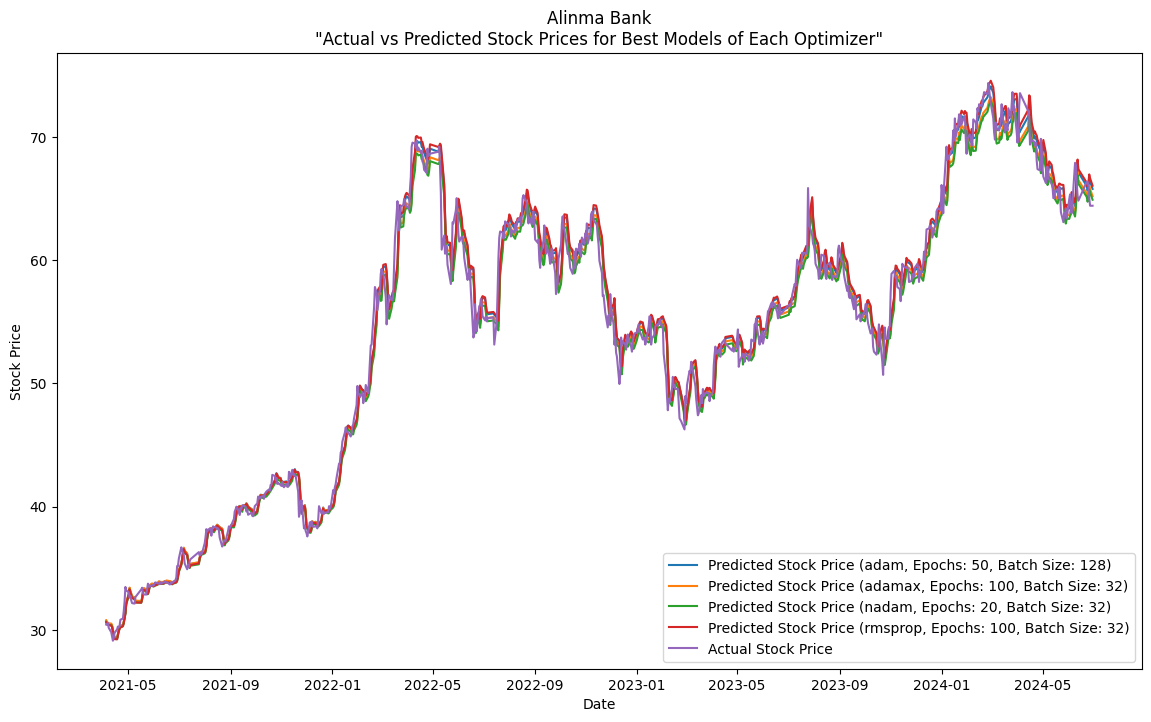

In [19]:
# Plotting the results for the best model of each optimizer
plt.figure(figsize=(14, 8))
for optimizer, (best_rmse, epochs, batch_size) in best_params.items():
    model = best_models[optimizer]
    y_pred = model.predict(X_test1)
    y_test_inv = scaler.inverse_transform(y_test1.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)
    
    plt.plot(alinma_train_data['Date'][split1+window_size:], y_pred_inv, label=f'Predicted Stock Price ({optimizer}, Epochs: {epochs}, Batch Size: {batch_size})')

plt.plot(alinma_train_data['Date'][split1+window_size:], y_test_inv, label='Actual Stock Price')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Alinma Bank\n"Actual vs Predicted Stock Prices for Best Models of Each Optimizer"')
plt.show()

# <span style="color:#E888BB; font-size: 1%;">2 | Alrajhi Bank Model </span>
<div style="padding: 35px;color:white;margin:10;font-size:170%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQbDkpIvhGvyOIyULyNV_W4HOKobW4xvaWkZA&s)"><b><span style='color:black'>2 | Alrajhi Bank Model </span></b> </div>

In [20]:
# Experiment with different optimizers, epoch numbers, and batch sizes
optimizers = ['adam', 'adamax', 'nadam', 'rmsprop']
epoch_numbers = [20, 50, 100]
batch_sizes = [32, 64, 128, 256]
results = []
best_rmse = float('inf')
best_models = {optimizer: None for optimizer in optimizers}
best_params = {optimizer: (float('inf'), None, None) for optimizer in optimizers}

In [21]:
for optimizer in optimizers:
    for epochs in epoch_numbers:
        for batch_size in batch_sizes:
            model = build_model(optimizer)
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            history = model.fit(X_train2, y_train2, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping])
            
            # Evaluate the Model
            y_pred = model.predict(X_test2)
            y_test_inv = scaler.inverse_transform(y_test2.reshape(-1, 1))
            y_pred_inv = scaler.inverse_transform(y_pred)
            
            mse = mean_squared_error(y_test_inv, y_pred_inv)
            mae = mean_absolute_error(y_test_inv, y_pred_inv)
            rmse = np.sqrt(mse)
            
            results.append((optimizer, epochs, batch_size, mse, mae, rmse))
            
            # Save the best model for each optimizer
            if optimizer not in best_params or rmse < best_params[optimizer][0]:
                best_params[optimizer] = (rmse, epochs, batch_size)
                best_models[optimizer] = model
                model.save(f'alrajhi_{optimizer}_best_model.h5')

Epoch 1/20
129/129 [==============================] - 6s 24ms/step - loss: 0.0044 - val_loss: 1.0618e-04
Epoch 2/20
129/129 [==============================] - 2s 18ms/step - loss: 1.3772e-04 - val_loss: 2.4944e-05
Epoch 3/20
129/129 [==============================] - 2s 18ms/step - loss: 1.1981e-04 - val_loss: 3.0358e-05
Epoch 4/20
129/129 [==============================] - 2s 13ms/step - loss: 1.1867e-04 - val_loss: 2.4909e-05
Epoch 5/20
129/129 [==============================] - 2s 19ms/step - loss: 1.2442e-04 - val_loss: 2.8250e-05
Epoch 6/20
129/129 [==============================] - 2s 13ms/step - loss: 1.2090e-04 - val_loss: 2.8875e-05
Epoch 7/20
129/129 [==============================] - 2s 18ms/step - loss: 1.2209e-04 - val_loss: 1.2269e-04
Epoch 8/20
129/129 [==============================] - 3s 20ms/step - loss: 1.3154e-04 - val_loss: 2.6310e-05
Epoch 9/20
41/41 [==============================] - 1s 4ms/step
Epoch 1/20
65/65 [==============================] - 6s 52ms/step - l

In [22]:
# Display the results
for result in results:
    print(f'Optimizer: {result[0]}, Epochs: {result[1]}, Batch Size: {result[2]}, MSE: {result[3]}, MAE: {result[4]}, RMSE: {result[5]}')

Optimizer: adam, Epochs: 20, Batch Size: 32, MSE: 0.8777799910566676, MAE: 0.6488721333281166, RMSE: 0.9368991360102045
Optimizer: adam, Epochs: 20, Batch Size: 64, MSE: 0.8797184469630475, MAE: 0.7024351717993611, RMSE: 0.9379330716863797
Optimizer: adam, Epochs: 20, Batch Size: 128, MSE: 0.9699269285574109, MAE: 0.7103058358510818, RMSE: 0.9848486830764465
Optimizer: adam, Epochs: 20, Batch Size: 256, MSE: 1.0374774308076813, MAE: 0.7279661235624342, RMSE: 1.018566360532136
Optimizer: adam, Epochs: 50, Batch Size: 32, MSE: 0.9438926158231017, MAE: 0.6942588928358456, RMSE: 0.9715413608401351
Optimizer: adam, Epochs: 50, Batch Size: 64, MSE: 0.7849872482921524, MAE: 0.6171812597733848, RMSE: 0.8859950610991871
Optimizer: adam, Epochs: 50, Batch Size: 128, MSE: 4.583546230093002, MAE: 1.5815456619977835, RMSE: 2.140921817837588
Optimizer: adam, Epochs: 50, Batch Size: 256, MSE: 0.8558019062250457, MAE: 0.659870216437344, RMSE: 0.9250956200442447
Optimizer: adam, Epochs: 100, Batch Size

41/41 [==============================] - 0s 4ms/step


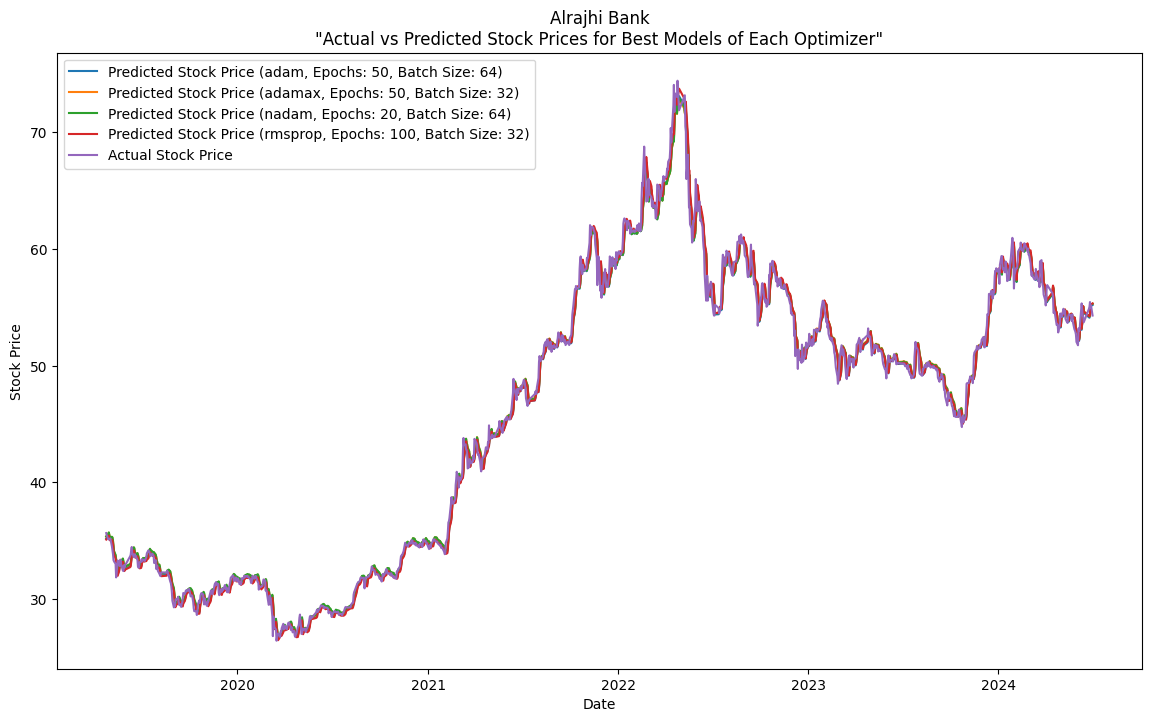

In [23]:
# Plotting the results for the best model of each optimizer
plt.figure(figsize=(14, 8))
for optimizer, (best_rmse, epochs, batch_size) in best_params.items():
    model = best_models[optimizer]
    y_pred = model.predict(X_test2)
    y_test_inv = scaler.inverse_transform(y_test2.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)
    
    plt.plot(alrajhi_train_data['Date'][split2+window_size:], y_pred_inv, label=f'Predicted Stock Price ({optimizer}, Epochs: {epochs}, Batch Size: {batch_size})')

plt.plot(alrajhi_train_data['Date'][split2+window_size:], y_test_inv, label='Actual Stock Price')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Alrajhi Bank\n"Actual vs Predicted Stock Prices for Best Models of Each Optimizer"')
plt.show()

# <span style="color:#E888BB; font-size: 1%;">3 | Saudi Steel Pipe Company Model </span>
<div style="padding: 35px;color:white;margin:10;font-size:170%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQbDkpIvhGvyOIyULyNV_W4HOKobW4xvaWkZA&s)"><b><span style='color:black'>3 | Saudi Steel Pipe Company Model </span></b> </div>

In [24]:
# Experiment with different optimizers, epoch numbers, and batch sizes
optimizers = ['adam', 'adamax', 'nadam', 'rmsprop']
epoch_numbers = [20, 50, 100]
batch_sizes = [32, 64, 128, 256]
results = []
best_rmse = float('inf')
best_models = {optimizer: None for optimizer in optimizers}
best_params = {optimizer: (float('inf'), None, None) for optimizer in optimizers}

In [25]:
for optimizer in optimizers:
    for epochs in epoch_numbers:
        for batch_size in batch_sizes:
            model = build_model(optimizer)
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            history = model.fit(X_train3, y_train3, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping])
            
            # Evaluate the Model
            y_pred = model.predict(X_test3)
            y_test_inv = scaler.inverse_transform(y_test3.reshape(-1, 1))
            y_pred_inv = scaler.inverse_transform(y_pred)
            
            mse = mean_squared_error(y_test_inv, y_pred_inv)
            mae = mean_absolute_error(y_test_inv, y_pred_inv)
            rmse = np.sqrt(mse)
            
            results.append((optimizer, epochs, batch_size, mse, mae, rmse))
            
            # Save the best model for each optimizer
            if optimizer not in best_params or rmse < best_params[optimizer][0]:
                best_params[optimizer] = (rmse, epochs, batch_size)
                best_models[optimizer] = model
                model.save(f'sspc_{optimizer}_best_model.h5')

Epoch 1/20
75/75 [==============================] - 6s 34ms/step - loss: 0.0048 - val_loss: 3.6739e-04
Epoch 2/20
75/75 [==============================] - 2s 22ms/step - loss: 1.0909e-04 - val_loss: 1.0318e-04
Epoch 3/20
75/75 [==============================] - 1s 16ms/step - loss: 9.3805e-05 - val_loss: 1.0916e-04
Epoch 4/20
75/75 [==============================] - 2s 23ms/step - loss: 9.4878e-05 - val_loss: 1.0342e-04
Epoch 5/20
75/75 [==============================] - 1s 15ms/step - loss: 9.5169e-05 - val_loss: 1.0722e-04
Epoch 6/20
75/75 [==============================] - 2s 21ms/step - loss: 9.3587e-05 - val_loss: 1.1858e-04
Epoch 7/20
24/24 [==============================] - 1s 4ms/step
Epoch 1/20
38/38 [==============================] - 5s 55ms/step - loss: 0.0077 - val_loss: 0.0017
Epoch 2/20
38/38 [==============================] - 2s 49ms/step - loss: 0.0013 - val_loss: 1.7432e-04
Epoch 3/20
38/38 [==============================] - 2s 50ms/step - loss: 1.0804e-04 - val_loss: 

In [26]:
# Display the results
for result in results:
    print(f'Optimizer: {result[0]}, Epochs: {result[1]}, Batch Size: {result[2]}, MSE: {result[3]}, MAE: {result[4]}, RMSE: {result[5]}')

Optimizer: adam, Epochs: 20, Batch Size: 32, MSE: 6.367608693412224, MAE: 1.1274106181806713, RMSE: 2.5234121132728644
Optimizer: adam, Epochs: 20, Batch Size: 64, MSE: 1.7713595713669161, MAE: 0.7015902622716486, RMSE: 1.3309243296923068
Optimizer: adam, Epochs: 20, Batch Size: 128, MSE: 2.8186961930385612, MAE: 0.8555657619084392, RMSE: 1.6788973146200934
Optimizer: adam, Epochs: 20, Batch Size: 256, MSE: 7.18549959748718, MAE: 1.1747045362494228, RMSE: 2.68057822073656
Optimizer: adam, Epochs: 50, Batch Size: 32, MSE: 1.300709996305408, MAE: 0.6300776459164401, RMSE: 1.1404867365758393
Optimizer: adam, Epochs: 50, Batch Size: 64, MSE: 5.891282859271745, MAE: 1.1019349752433767, RMSE: 2.427196501989846
Optimizer: adam, Epochs: 50, Batch Size: 128, MSE: 5.702366486457317, MAE: 1.0874531476545528, RMSE: 2.3879628318835526
Optimizer: adam, Epochs: 50, Batch Size: 256, MSE: 4.991169339152578, MAE: 1.0324562483451545, RMSE: 2.2340925090856416
Optimizer: adam, Epochs: 100, Batch Size: 32, 

24/24 [==============================] - 0s 8ms/step


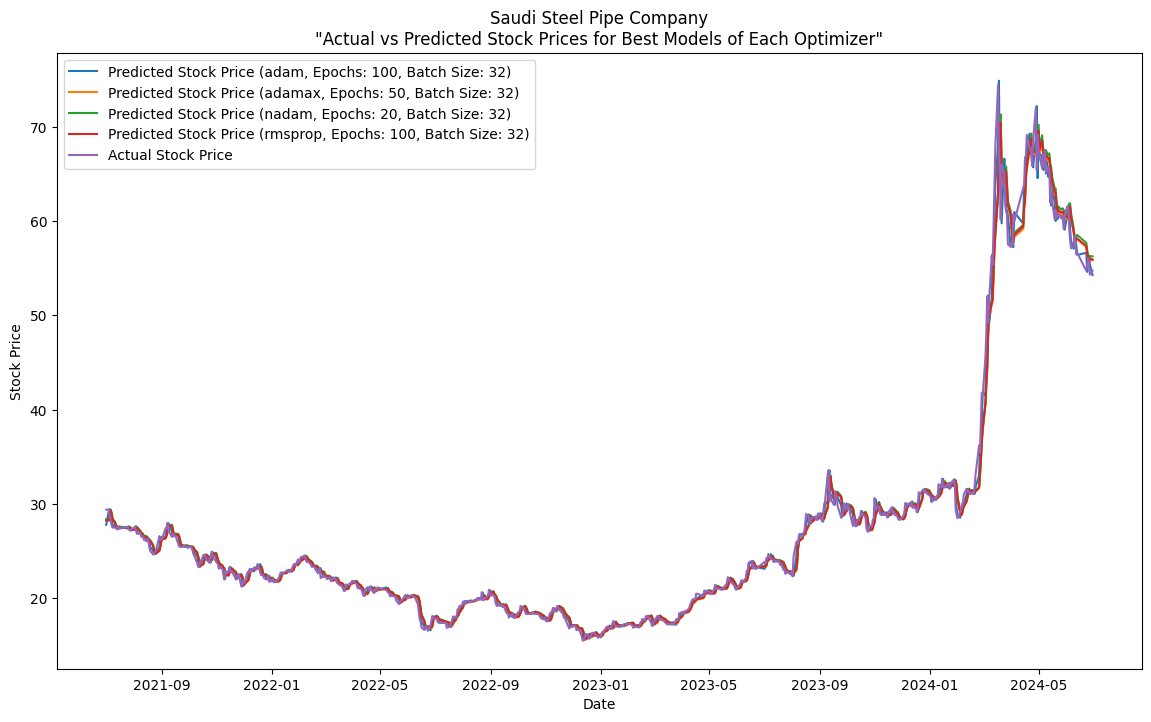

In [27]:
# Plotting the results for the best model of each optimizer
plt.figure(figsize=(14, 8))
for optimizer, (best_rmse, epochs, batch_size) in best_params.items():
    model = best_models[optimizer]
    y_pred = model.predict(X_test3)
    y_test_inv = scaler.inverse_transform(y_test3.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)
    
    plt.plot(sspc_train_data['Date'][split3+window_size:], y_pred_inv, label=f'Predicted Stock Price ({optimizer}, Epochs: {epochs}, Batch Size: {batch_size})')

plt.plot(sspc_train_data['Date'][split3+window_size:], y_test_inv, label='Actual Stock Price')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Saudi Steel Pipe Company\n"Actual vs Predicted Stock Prices for Best Models of Each Optimizer"')
plt.show()

# <span style="color:#E888BB; font-size: 1%;">4 | Saudi Basic Industries Corp "SABIC" Model </span>
<div style="padding: 35px;color:white;margin:10;font-size:170%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQbDkpIvhGvyOIyULyNV_W4HOKobW4xvaWkZA&s)"><b><span style='color:black'>4 | Saudi Basic Industries Corp "SABIC" Model </span></b> </div>

In [28]:
# Experiment with different optimizers, epoch numbers, and batch sizes
optimizers = ['adam', 'adamax', 'nadam', 'rmsprop']
epoch_numbers = [20, 50, 100]
batch_sizes = [32, 64, 128, 256]
results = []
best_rmse = float('inf')
best_models = {optimizer: None for optimizer in optimizers}
best_params = {optimizer: (float('inf'), None, None) for optimizer in optimizers}

In [29]:
for optimizer in optimizers:
    for epochs in epoch_numbers:
        for batch_size in batch_sizes:
            model = build_model(optimizer)
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            history = model.fit(X_train4, y_train4, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping])
            
            # Evaluate the Model
            y_pred = model.predict(X_test4)
            y_test_inv = scaler.inverse_transform(y_test4.reshape(-1, 1))
            y_pred_inv = scaler.inverse_transform(y_pred)
            
            mse = mean_squared_error(y_test_inv, y_pred_inv)
            mae = mean_absolute_error(y_test_inv, y_pred_inv)
            rmse = np.sqrt(mse)
            
            results.append((optimizer, epochs, batch_size, mse, mae, rmse))
            
            # Save the best model for each optimizer
            if optimizer not in best_params or rmse < best_params[optimizer][0]:
                best_params[optimizer] = (rmse, epochs, batch_size)
                best_models[optimizer] = model
                model.save(f'sabic_{optimizer}_best_model.h5')

Epoch 1/20
117/117 [==============================] - 6s 21ms/step - loss: 0.0204 - val_loss: 1.5449e-04
Epoch 2/20
117/117 [==============================] - 2s 20ms/step - loss: 4.5170e-04 - val_loss: 1.3611e-04
Epoch 3/20
117/117 [==============================] - 2s 20ms/step - loss: 2.8913e-04 - val_loss: 6.0209e-05
Epoch 4/20
117/117 [==============================] - 2s 20ms/step - loss: 2.7189e-04 - val_loss: 6.0529e-05
Epoch 5/20
117/117 [==============================] - 2s 16ms/step - loss: 2.7643e-04 - val_loss: 1.9890e-04
Epoch 6/20
117/117 [==============================] - 2s 20ms/step - loss: 2.7296e-04 - val_loss: 5.6649e-05
Epoch 7/20
117/117 [==============================] - 2s 16ms/step - loss: 2.8209e-04 - val_loss: 6.1226e-05
Epoch 8/20
117/117 [==============================] - 2s 20ms/step - loss: 2.7860e-04 - val_loss: 7.0013e-05
Epoch 9/20
117/117 [==============================] - 2s 20ms/step - loss: 2.7221e-04 - val_loss: 6.7637e-05
Epoch 10/20
117/117 [==

In [30]:
# Display the results
for result in results:
    print(f'Optimizer: {result[0]}, Epochs: {result[1]}, Batch Size: {result[2]}, MSE: {result[3]}, MAE: {result[4]}, RMSE: {result[5]}')

Optimizer: adam, Epochs: 20, Batch Size: 32, MSE: 0.3095106520109094, MAE: 0.40192475402228056, RMSE: 0.5563368152575464
Optimizer: adam, Epochs: 20, Batch Size: 64, MSE: 0.3159567524129194, MAE: 0.40277960397484486, RMSE: 0.5621003045835498
Optimizer: adam, Epochs: 20, Batch Size: 128, MSE: 0.30577984279858633, MAE: 0.391940844740597, RMSE: 0.5529736366216624
Optimizer: adam, Epochs: 20, Batch Size: 256, MSE: 0.30564414843374127, MAE: 0.39298451868879253, RMSE: 0.5528509278582621
Optimizer: adam, Epochs: 50, Batch Size: 32, MSE: 0.2982476828178608, MAE: 0.38874987734915883, RMSE: 0.5461205753474784
Optimizer: adam, Epochs: 50, Batch Size: 64, MSE: 0.3034557015559181, MAE: 0.38989229755427374, RMSE: 0.5508681344531721
Optimizer: adam, Epochs: 50, Batch Size: 128, MSE: 0.3040664443640072, MAE: 0.3900144795109343, RMSE: 0.5514222015515944
Optimizer: adam, Epochs: 50, Batch Size: 256, MSE: 0.3164534775271246, MAE: 0.4058604624837947, RMSE: 0.5625419784577188
Optimizer: adam, Epochs: 100, 

37/37 [==============================] - 0s 5ms/step


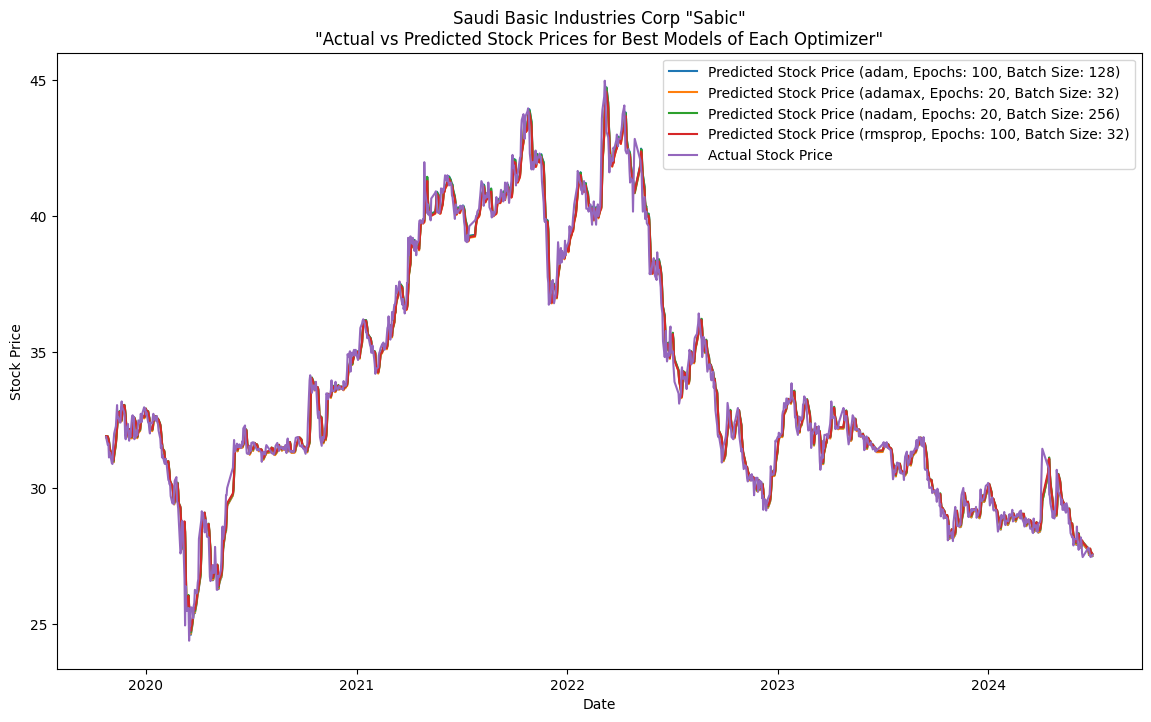

In [31]:
# Plotting the results for the best model of each optimizer
plt.figure(figsize=(14, 8))
for optimizer, (best_rmse, epochs, batch_size) in best_params.items():
    model = best_models[optimizer]
    y_pred = model.predict(X_test4)
    y_test_inv = scaler.inverse_transform(y_test4.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)
    
    plt.plot(sabic_train_data['Date'][split4+window_size:], y_pred_inv, label=f'Predicted Stock Price ({optimizer}, Epochs: {epochs}, Batch Size: {batch_size})')

plt.plot(sabic_train_data['Date'][split4+window_size:], y_test_inv, label='Actual Stock Price')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Saudi Basic Industries Corp "Sabic"\n"Actual vs Predicted Stock Prices for Best Models of Each Optimizer"')
plt.show()

# <span style="color:#E888BB; font-size: 1%;">5 | Saudi Telecom Company "STC" Model </span>
<div style="padding: 35px;color:white;margin:10;font-size:170%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQbDkpIvhGvyOIyULyNV_W4HOKobW4xvaWkZA&s)"><b><span style='color:black'>5 | Saudi Telecom Company "STC" Model </span></b> </div>

In [32]:
# Experiment with different optimizers, epoch numbers, and batch sizes
optimizers = ['adam', 'adamax', 'nadam', 'rmsprop']
epoch_numbers = [20, 50, 100]
batch_sizes = [32, 64, 128, 256]
results = []
best_rmse = float('inf')
best_models = {optimizer: None for optimizer in optimizers}
best_params = {optimizer: (float('inf'), None, None) for optimizer in optimizers}

In [33]:
for optimizer in optimizers:
    for epochs in epoch_numbers:
        for batch_size in batch_sizes:
            model = build_model(optimizer)
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            history = model.fit(X_train5, y_train5, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping])
            
            # Evaluate the Model
            y_pred = model.predict(X_test5)
            y_test_inv = scaler.inverse_transform(y_test5.reshape(-1, 1))
            y_pred_inv = scaler.inverse_transform(y_pred)
            
            mse = mean_squared_error(y_test_inv, y_pred_inv)
            mae = mean_absolute_error(y_test_inv, y_pred_inv)
            rmse = np.sqrt(mse)
            
            results.append((optimizer, epochs, batch_size, mse, mae, rmse))
            
            # Save the best model for each optimizer
            if optimizer not in best_params or rmse < best_params[optimizer][0]:
                best_params[optimizer] = (rmse, epochs, batch_size)
                best_models[optimizer] = model
                model.save(f'stc_{optimizer}_best_model.h5')

Epoch 1/20
111/111 [==============================] - 6s 23ms/step - loss: 0.0119 - val_loss: 1.6685e-04
Epoch 2/20
111/111 [==============================] - 2s 21ms/step - loss: 3.4507e-04 - val_loss: 1.7493e-04
Epoch 3/20
111/111 [==============================] - 2s 21ms/step - loss: 2.8065e-04 - val_loss: 1.7547e-04
Epoch 4/20
111/111 [==============================] - 2s 22ms/step - loss: 2.5905e-04 - val_loss: 1.5524e-04
Epoch 5/20
111/111 [==============================] - 2s 16ms/step - loss: 2.6012e-04 - val_loss: 1.5180e-04
Epoch 6/20
111/111 [==============================] - 2s 21ms/step - loss: 2.8303e-04 - val_loss: 1.4054e-04
Epoch 7/20
111/111 [==============================] - 2s 15ms/step - loss: 2.7844e-04 - val_loss: 1.7992e-04
Epoch 8/20
111/111 [==============================] - 2s 22ms/step - loss: 2.7614e-04 - val_loss: 1.4933e-04
Epoch 9/20
111/111 [==============================] - 2s 16ms/step - loss: 2.6475e-04 - val_loss: 2.6382e-04
Epoch 10/20
111/111 [==

In [34]:
# Display the results
for result in results:
    print(f'Optimizer: {result[0]}, Epochs: {result[1]}, Batch Size: {result[2]}, MSE: {result[3]}, MAE: {result[4]}, RMSE: {result[5]}')

Optimizer: adam, Epochs: 20, Batch Size: 32, MSE: 0.8266121728702845, MAE: 0.7308121693513278, RMSE: 0.9091821450459113
Optimizer: adam, Epochs: 20, Batch Size: 64, MSE: 0.5512823307109636, MAE: 0.5432026603068149, RMSE: 0.7424838925599421
Optimizer: adam, Epochs: 20, Batch Size: 128, MSE: 0.5841197584779213, MAE: 0.5746325384238766, RMSE: 0.7642772785304567
Optimizer: adam, Epochs: 20, Batch Size: 256, MSE: 0.7160394318816459, MAE: 0.6408788679297898, RMSE: 0.8461911320036661
Optimizer: adam, Epochs: 50, Batch Size: 32, MSE: 0.5432144310596072, MAE: 0.5364088103859993, RMSE: 0.7370308209699288
Optimizer: adam, Epochs: 50, Batch Size: 64, MSE: 0.6958284127981231, MAE: 0.6130599392120893, RMSE: 0.8341633010377064
Optimizer: adam, Epochs: 50, Batch Size: 128, MSE: 0.5341528533107242, MAE: 0.5324402401514426, RMSE: 0.7308576149365376
Optimizer: adam, Epochs: 50, Batch Size: 256, MSE: 0.6752299138595103, MAE: 0.6041829729210134, RMSE: 0.8217237454640764
Optimizer: adam, Epochs: 100, Batch 

35/35 [==============================] - 0s 8ms/step


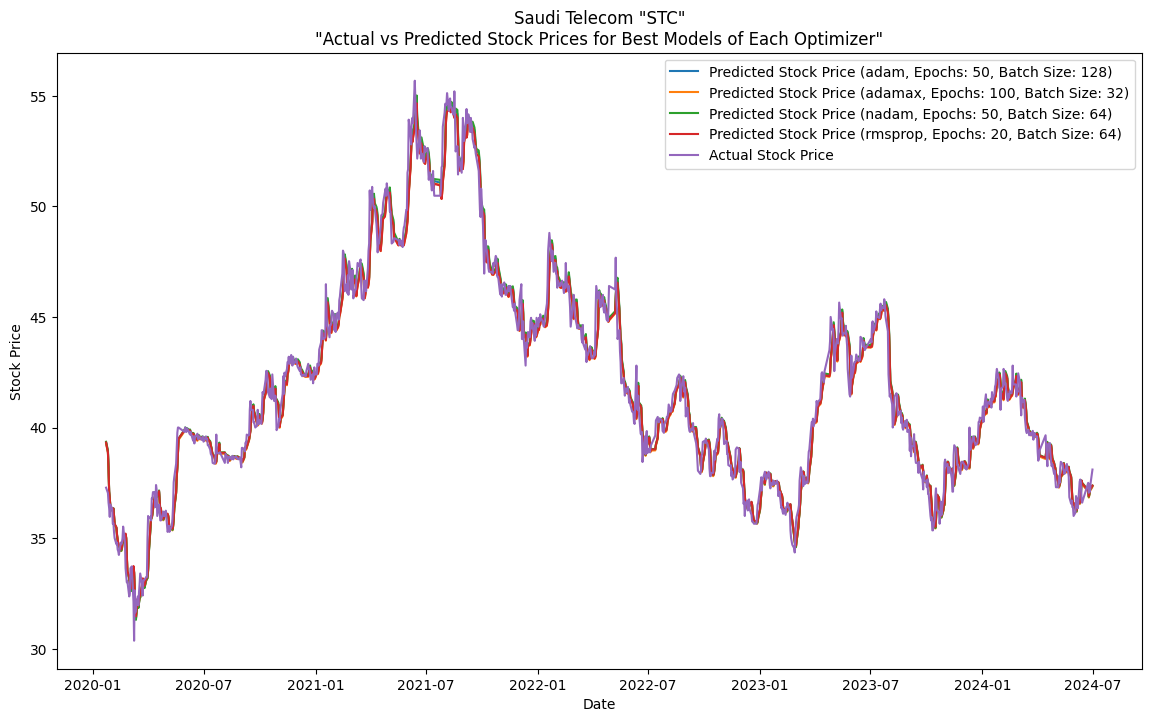

In [35]:
# Plotting the results for the best model of each optimizer
plt.figure(figsize=(14, 8))
for optimizer, (best_rmse, epochs, batch_size) in best_params.items():
    model = best_models[optimizer]
    y_pred = model.predict(X_test5)
    y_test_inv = scaler.inverse_transform(y_test5.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)
    
    plt.plot(stc_train_data['Date'][split5+window_size:], y_pred_inv, label=f'Predicted Stock Price ({optimizer}, Epochs: {epochs}, Batch Size: {batch_size})')

plt.plot(stc_train_data['Date'][split5+window_size:], y_test_inv, label='Actual Stock Price')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Saudi Telecom "STC"\n"Actual vs Predicted Stock Prices for Best Models of Each Optimizer"')
plt.show()

# Testing phase on unseen data

## 1- Alinma Bank

In [41]:
# Load the unseen data
unseen_data = pd.read_csv('1150-Historical-Data-test.csv')

In [42]:
# Preprocess the unseen data
unseen_data['Date'] = pd.to_datetime(unseen_data['Date'])
unseen_data = unseen_data.sort_values('Date')

In [43]:
# Use only the 'Close' column for simplicity
unseen_close_prices = unseen_data['Price'].values.reshape(-1, 1)

In [44]:
# Use only the 'Close' column for simplicity
unseen_close_prices = unseen_data['Price'].values.reshape(-1, 1)

In [45]:
# Scale the unseen data using the same scaler fitted on the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_unseen_close = scaler.fit_transform(unseen_close_prices)

In [46]:
# Create sequences with a window of 3 for the unseen data
window_size = 3
X_unseen, y_unseen = create_sequences(scaled_unseen_close, window_size)

In [47]:
# Ensure the unseen data is not empty
if len(X_unseen) == 0:
    raise ValueError("The unseen data does not have enough samples to create sequences.")

In [48]:
# Reshape X_unseen to be 3D [samples, time steps, features]
X_unseen = X_unseen.reshape((X_unseen.shape[0], X_unseen.shape[1], 1))

In [49]:
# List of model file names
model_files = [
    'alinma_adam_best_model.h5', 'alinma_adamax_best_model.h5', 
    'alinma_nadam_best_model.h5', 'alinma_rmsprop_best_model.h5'
]

In [50]:
# Dictionary to store the results
results = {}

In [51]:
# Loop through each model and make predictions
for model_file in model_files:
    model = load_model(model_file)
    y_unseen_pred = model.predict(X_unseen)

    # Inverse transform the predictions and actual values
    y_unseen_inv = scaler.inverse_transform(y_unseen.reshape(-1, 1))
    y_unseen_pred_inv = scaler.inverse_transform(y_unseen_pred)

    # Calculate evaluation metrics for the unseen data
    mse_unseen = mean_squared_error(y_unseen_inv, y_unseen_pred_inv)
    mae_unseen = mean_absolute_error(y_unseen_inv, y_unseen_pred_inv)
    rmse_unseen = np.sqrt(mse_unseen)

    results[model_file] = {
        'mse': mse_unseen,
        'mae': mae_unseen,
        'rmse': rmse_unseen,
        'y_pred_inv': y_unseen_pred_inv
    }

1/1 [==============================] - 1s 1s/step


In [52]:
# Print the results
for model_file, metrics in results.items():
    print(f'Model: {model_file}')
    print(f'MSE: {metrics["mse"]}')
    print(f'MAE: {metrics["mae"]}')
    print(f'RMSE: {metrics["rmse"]}')
    print('')

Model: alinma_adam_best_model.h5
MSE: 0.11883307827003885
MAE: 0.28340410978897723
RMSE: 0.3447217403501538

Model: alinma_adamax_best_model.h5
MSE: 0.11873265520482852
MAE: 0.2828381248142405
RMSE: 0.34457605140930575

Model: alinma_nadam_best_model.h5
MSE: 0.12105729203001807
MAE: 0.28534927368164026
RMSE: 0.3479328843757343

Model: alinma_rmsprop_best_model.h5
MSE: 0.11495052970278956
MAE: 0.2785234202509339
RMSE: 0.3390435513363874



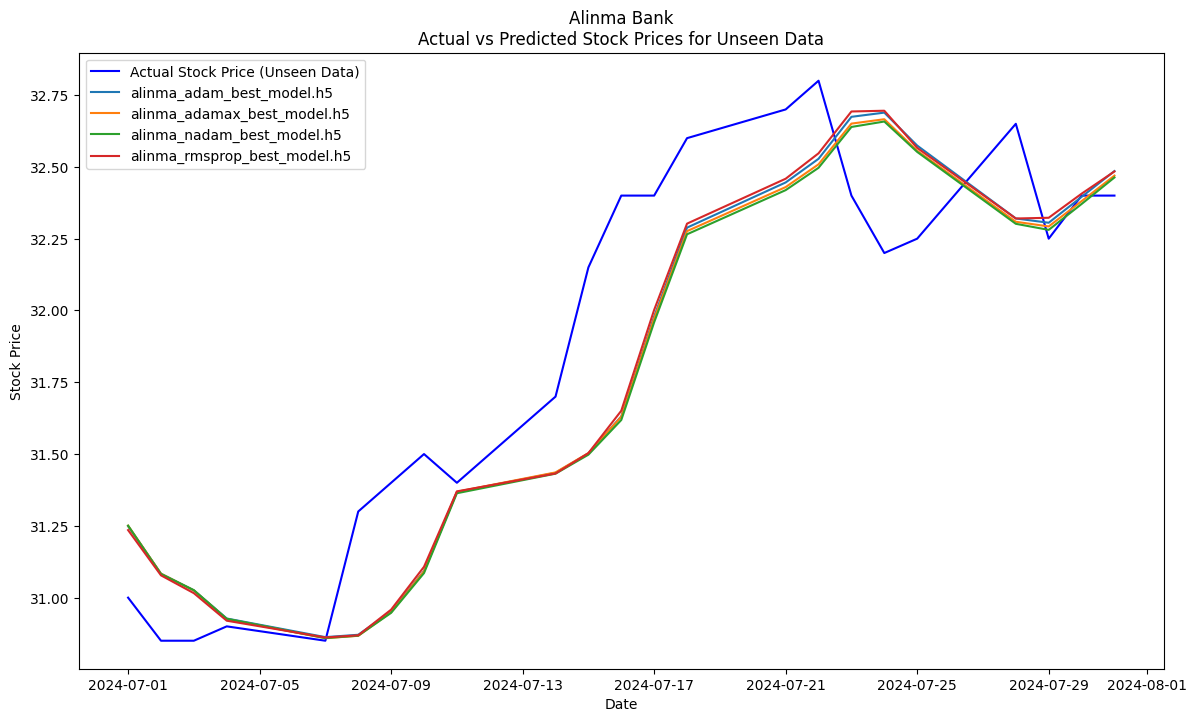

In [53]:
# Plot the results for the unseen data
plt.figure(figsize=(14, 8))
plt.plot(unseen_data['Date'][window_size:], y_unseen_inv, color='blue', label='Actual Stock Price (Unseen Data)')
for model_file, metrics in results.items():
    plt.plot(unseen_data['Date'][window_size:], metrics['y_pred_inv'], label=f'{model_file}')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Alinma Bank\nActual vs Predicted Stock Prices for Unseen Data')
plt.show()

## 2- Alrajhi Bank

In [54]:
# Load the unseen data
unseen_data = pd.read_csv('1120-Historical-Data-test.csv')

In [55]:
# Preprocess the unseen data
unseen_data['Date'] = pd.to_datetime(unseen_data['Date'])
unseen_data = unseen_data.sort_values('Date')

In [56]:
# Use only the 'Close' column for simplicity
unseen_close_prices = unseen_data['Price'].values.reshape(-1, 1)

In [57]:
# Scale the unseen data using the same scaler fitted on the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_unseen_close = scaler.fit_transform(unseen_close_prices)

In [58]:
# Create sequences with a window of 3 for the unseen data
window_size = 3
X_unseen, y_unseen = create_sequences(scaled_unseen_close, window_size)

In [59]:
# Ensure the unseen data is not empty
if len(X_unseen) == 0:
    raise ValueError("The unseen data does not have enough samples to create sequences.")

In [60]:
# Reshape X_unseen to be 3D [samples, time steps, features]
X_unseen = X_unseen.reshape((X_unseen.shape[0], X_unseen.shape[1], 1))

In [61]:
# List of model file names
model_files = [
    'alrajhi_adam_best_model.h5', 'alrajhi_adamax_best_model.h5', 
    'alrajhi_nadam_best_model.h5', 'alrajhi_rmsprop_best_model.h5'
]

In [62]:
# Dictionary to store the results
results = {}

In [63]:
# Loop through each model and make predictions
for model_file in model_files:
    model = load_model(model_file)
    y_unseen_pred = model.predict(X_unseen)

    # Inverse transform the predictions and actual values
    y_unseen_inv = scaler.inverse_transform(y_unseen.reshape(-1, 1))
    y_unseen_pred_inv = scaler.inverse_transform(y_unseen_pred)

    # Calculate evaluation metrics for the unseen data
    mse_unseen = mean_squared_error(y_unseen_inv, y_unseen_pred_inv)
    mae_unseen = mean_absolute_error(y_unseen_inv, y_unseen_pred_inv)
    rmse_unseen = np.sqrt(mse_unseen)

    results[model_file] = {
        'mse': mse_unseen,
        'mae': mae_unseen,
        'rmse': rmse_unseen,
        'y_pred_inv': y_unseen_pred_inv
    }

1/1 [==============================] - 1s 995ms/step


In [64]:
# Print the results
for model_file, metrics in results.items():
    print(f'Model: {model_file}')
    print(f'MSE: {metrics["mse"]}')
    print(f'MAE: {metrics["mae"]}')
    print(f'RMSE: {metrics["rmse"]}')
    print('')

Model: alrajhi_adam_best_model.h5
MSE: 1.056127401736218
MAE: 0.847599659795346
RMSE: 1.02768059324686

Model: alrajhi_adamax_best_model.h5
MSE: 1.0302739274574662
MAE: 0.8384181810461951
RMSE: 1.0150241019096375

Model: alrajhi_nadam_best_model.h5
MSE: 1.0780610472225034
MAE: 0.8582678753396734
RMSE: 1.0382971863693475

Model: alrajhi_rmsprop_best_model.h5
MSE: 1.0569617670204507
MAE: 0.8446712991465688
RMSE: 1.028086458922814



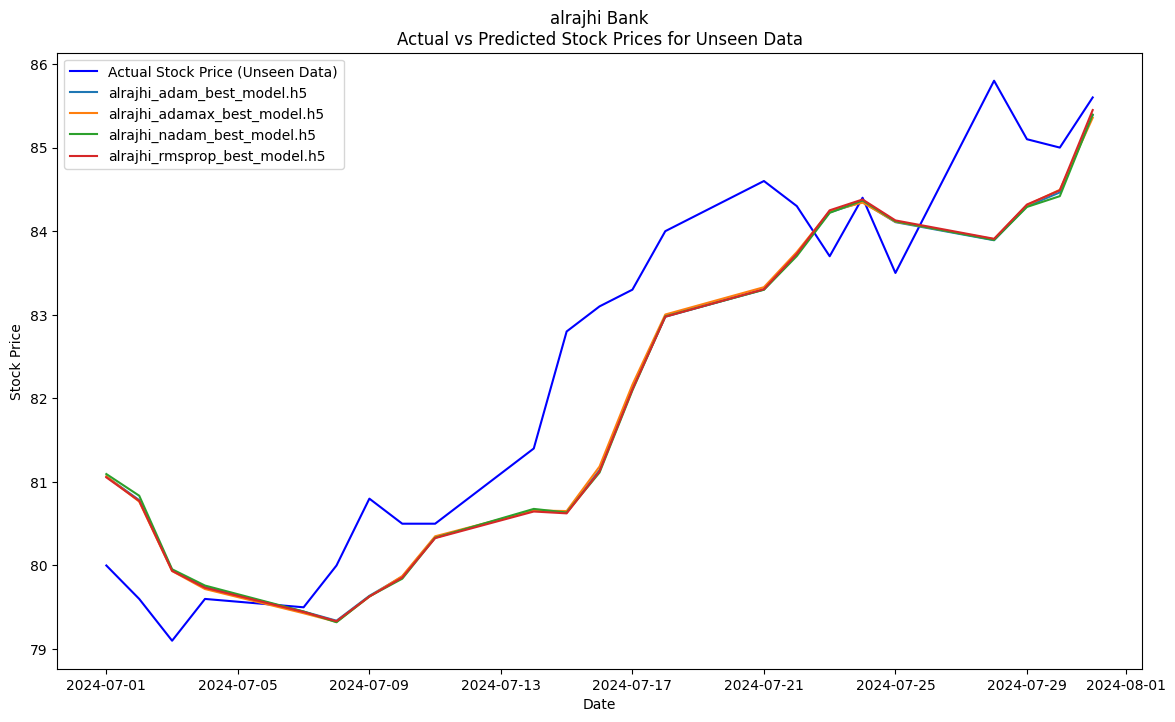

In [65]:
# Plot the results for the unseen data
plt.figure(figsize=(14, 8))
plt.plot(unseen_data['Date'][window_size:], y_unseen_inv, color='blue', label='Actual Stock Price (Unseen Data)')
for model_file, metrics in results.items():
    plt.plot(unseen_data['Date'][window_size:], metrics['y_pred_inv'], label=f'{model_file}')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('alrajhi Bank\nActual vs Predicted Stock Prices for Unseen Data')
plt.show()

## 3- Saudi Steel Pipe Company

In [66]:
# Load the unseen data
unseen_data = pd.read_csv('1320-Historical-Data-test.csv')

In [67]:
# Preprocess the unseen data
unseen_data['Date'] = pd.to_datetime(unseen_data['Date'])
unseen_data = unseen_data.sort_values('Date')

In [68]:
# Use only the 'Close' column for simplicity
unseen_close_prices = unseen_data['Price'].values.reshape(-1, 1)

In [69]:
# Scale the unseen data using the same scaler fitted on the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_unseen_close = scaler.fit_transform(unseen_close_prices)

In [70]:
# Create sequences with a window of 3 for the unseen data
window_size = 3
X_unseen, y_unseen = create_sequences(scaled_unseen_close, window_size)

In [71]:
# Ensure the unseen data is not empty
if len(X_unseen) == 0:
    raise ValueError("The unseen data does not have enough samples to create sequences.")

In [72]:
# Reshape X_unseen to be 3D [samples, time steps, features]
X_unseen = X_unseen.reshape((X_unseen.shape[0], X_unseen.shape[1], 1))

In [73]:
# List of model file names
model_files = [
    'sspc_adam_best_model.h5', 'sspc_adamax_best_model.h5', 
    'sspc_nadam_best_model.h5', 'sspc_rmsprop_best_model.h5'
]

In [74]:
# Dictionary to store the results
results = {}

In [75]:
# Loop through each model and make predictions
for model_file in model_files:
    model = load_model(model_file)
    y_unseen_pred = model.predict(X_unseen)

    # Inverse transform the predictions and actual values
    y_unseen_inv = scaler.inverse_transform(y_unseen.reshape(-1, 1))
    y_unseen_pred_inv = scaler.inverse_transform(y_unseen_pred)

    # Calculate evaluation metrics for the unseen data
    mse_unseen = mean_squared_error(y_unseen_inv, y_unseen_pred_inv)
    mae_unseen = mean_absolute_error(y_unseen_inv, y_unseen_pred_inv)
    rmse_unseen = np.sqrt(mse_unseen)

    results[model_file] = {
        'mse': mse_unseen,
        'mae': mae_unseen,
        'rmse': rmse_unseen,
        'y_pred_inv': y_unseen_pred_inv
    }

1/1 [==============================] - 1s 1s/step


In [76]:
# Print the results
for model_file, metrics in results.items():
    print(f'Model: {model_file}')
    print(f'MSE: {metrics["mse"]}')
    print(f'MAE: {metrics["mae"]}')
    print(f'RMSE: {metrics["rmse"]}')
    print('')

Model: sspc_adam_best_model.h5
MSE: 3.404625287910051
MAE: 1.2903358127759836
RMSE: 1.8451626724790557

Model: sspc_adamax_best_model.h5
MSE: 4.798810331342116
MAE: 1.5576213670813517
RMSE: 2.190618709712422

Model: sspc_nadam_best_model.h5
MSE: 4.816484865587125
MAE: 1.5725092348845109
RMSE: 2.194649144074543

Model: sspc_rmsprop_best_model.h5
MSE: 4.628672525710227
MAE: 1.525965284264606
RMSE: 2.1514349922110654



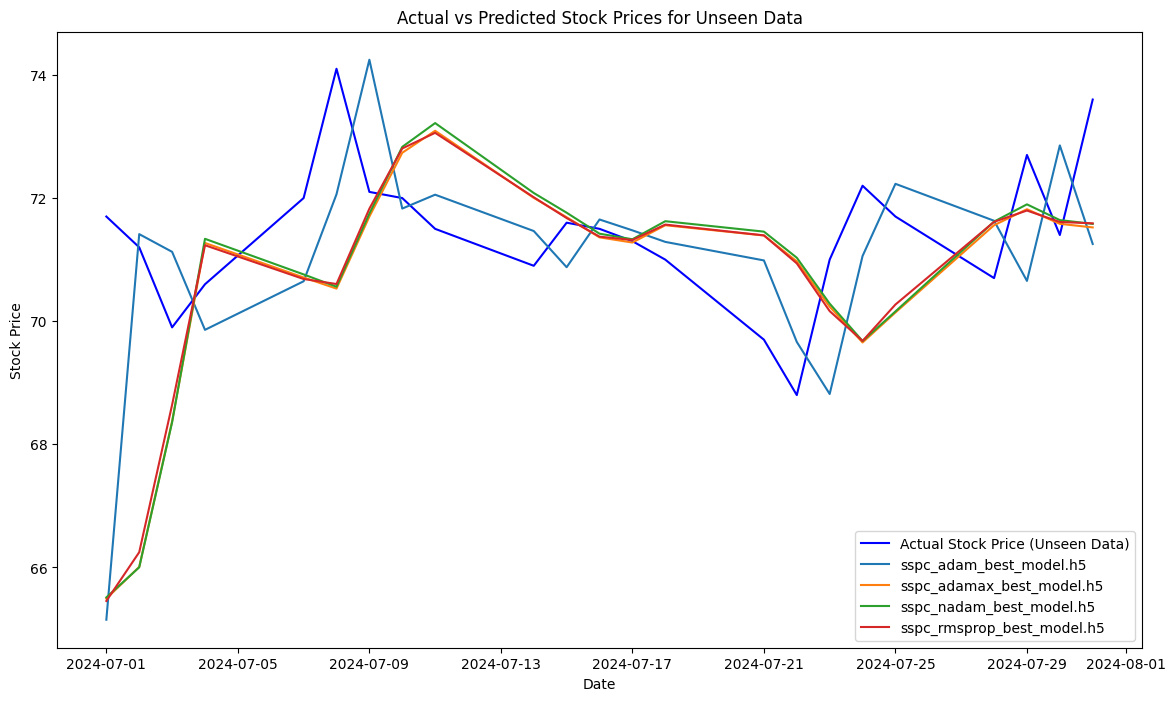

In [77]:
# Plot the results for the unseen data
plt.figure(figsize=(14, 8))
plt.plot(unseen_data['Date'][window_size:], y_unseen_inv, color='blue', label='Actual Stock Price (Unseen Data)')
for model_file, metrics in results.items():
    plt.plot(unseen_data['Date'][window_size:], metrics['y_pred_inv'], label=f'{model_file}')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Actual vs Predicted Stock Prices for Unseen Data')
plt.show()

## 4- Saudi Basic Corp ( Sabic )

In [78]:
# Load the unseen data
unseen_data = pd.read_csv('2010-Historical-Data-test.csv')

In [79]:
# Preprocess the unseen data
unseen_data['Date'] = pd.to_datetime(unseen_data['Date'])
unseen_data = unseen_data.sort_values('Date')

In [80]:
# Use only the 'Close' column for simplicity
unseen_close_prices = unseen_data['Price'].values.reshape(-1, 1)

In [81]:
# Scale the unseen data using the same scaler fitted on the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_unseen_close = scaler.fit_transform(unseen_close_prices)

In [82]:
# Create sequences with a window of 3 for the unseen data
window_size = 3
X_unseen, y_unseen = create_sequences(scaled_unseen_close, window_size)

In [83]:
# Ensure the unseen data is not empty
if len(X_unseen) == 0:
    raise ValueError("The unseen data does not have enough samples to create sequences.")

In [84]:
# Reshape X_unseen to be 3D [samples, time steps, features]
X_unseen = X_unseen.reshape((X_unseen.shape[0], X_unseen.shape[1], 1))

In [85]:
# List of model file names
model_files = [
    'sabic_adam_best_model.h5', 'sabic_adamax_best_model.h5', 
    'sabic_nadam_best_model.h5', 'sabic_rmsprop_best_model.h5'
]

In [86]:
# Dictionary to store the results
results = {}

In [87]:
# Loop through each model and make predictions
for model_file in model_files:
    model = load_model(model_file)
    y_unseen_pred = model.predict(X_unseen)

    # Inverse transform the predictions and actual values
    y_unseen_inv = scaler.inverse_transform(y_unseen.reshape(-1, 1))
    y_unseen_pred_inv = scaler.inverse_transform(y_unseen_pred)

    # Calculate evaluation metrics for the unseen data
    mse_unseen = mean_squared_error(y_unseen_inv, y_unseen_pred_inv)
    mae_unseen = mean_absolute_error(y_unseen_inv, y_unseen_pred_inv)
    rmse_unseen = np.sqrt(mse_unseen)

    results[model_file] = {
        'mse': mse_unseen,
        'mae': mae_unseen,
        'rmse': rmse_unseen,
        'y_pred_inv': y_unseen_pred_inv
    }

1/1 [==============================] - 1s 1s/step


In [88]:
# Print the results
for model_file, metrics in results.items():
    print(f'Model: {model_file}')
    print(f'MSE: {metrics["mse"]}')
    print(f'MAE: {metrics["mae"]}')
    print(f'RMSE: {metrics["rmse"]}')
    print('')

Model: sabic_adam_best_model.h5
MSE: 1.3813301394389859
MAE: 0.8423968771229616
RMSE: 1.1753000210324962

Model: sabic_adamax_best_model.h5
MSE: 1.3860000694388237
MAE: 0.8444226472274113
RMSE: 1.177285041711999

Model: sabic_nadam_best_model.h5
MSE: 1.4171453267219474
MAE: 0.8530803514563515
RMSE: 1.1904391318845107

Model: sabic_rmsprop_best_model.h5
MSE: 1.3046840191818774
MAE: 0.8188578730044154
RMSE: 1.142227656459901



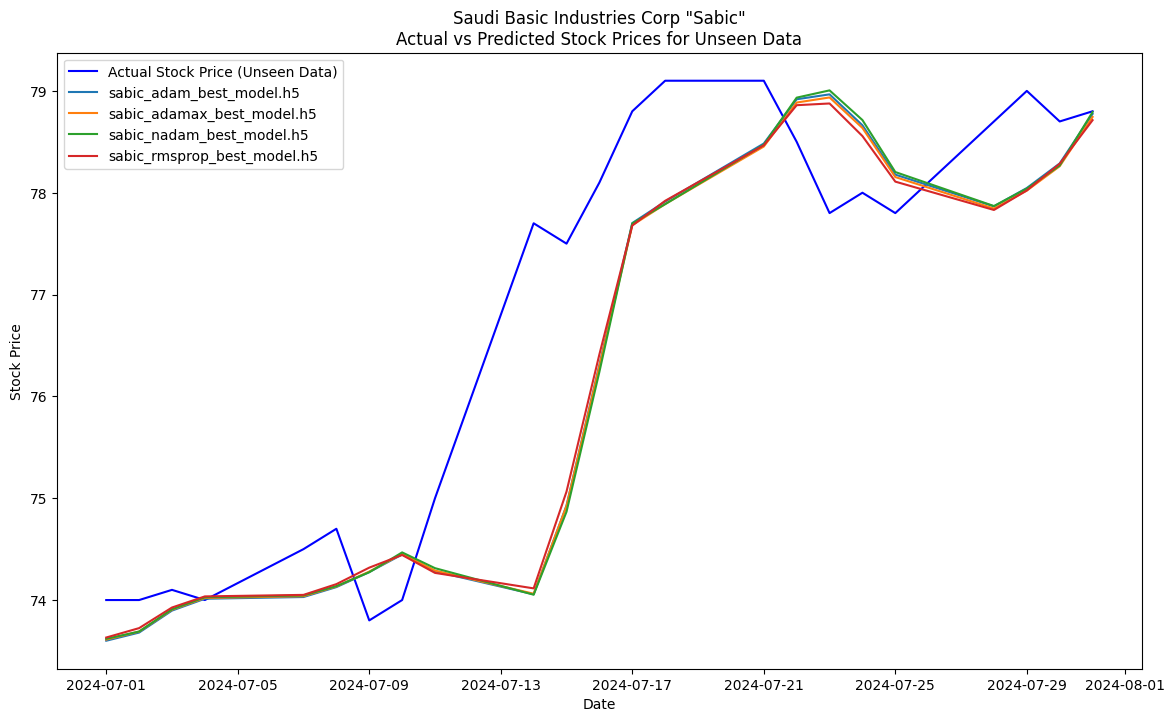

In [89]:
# Plot the results for the unseen data
plt.figure(figsize=(14, 8))
plt.plot(unseen_data['Date'][window_size:], y_unseen_inv, color='blue', label='Actual Stock Price (Unseen Data)')
for model_file, metrics in results.items():
    plt.plot(unseen_data['Date'][window_size:], metrics['y_pred_inv'], label=f'{model_file}')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Saudi Basic Industries Corp "Sabic"\nActual vs Predicted Stock Prices for Unseen Data')
plt.show()

## 5- Saudi Telecom Company ( STC )

In [90]:
# Load the unseen data
unseen_data = pd.read_csv('7010-Historical-Data-test.csv')

In [91]:
# Preprocess the unseen data
unseen_data['Date'] = pd.to_datetime(unseen_data['Date'])
unseen_data = unseen_data.sort_values('Date')

In [92]:
# Use only the 'Close' column for simplicity
unseen_close_prices = unseen_data['Price'].values.reshape(-1, 1)

In [93]:
# Scale the unseen data using the same scaler fitted on the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_unseen_close = scaler.fit_transform(unseen_close_prices)

In [94]:
# Create sequences with a window of 3 for the unseen data
window_size = 3
X_unseen, y_unseen = create_sequences(scaled_unseen_close, window_size)

In [95]:
# Ensure the unseen data is not empty
if len(X_unseen) == 0:
    raise ValueError("The unseen data does not have enough samples to create sequences.")

In [96]:
# Reshape X_unseen to be 3D [samples, time steps, features]
X_unseen = X_unseen.reshape((X_unseen.shape[0], X_unseen.shape[1], 1))

In [97]:
# List of model file names
model_files = [
    'stc_adam_best_model.h5', 'stc_adamax_best_model.h5', 
    'stc_nadam_best_model.h5', 'stc_rmsprop_best_model.h5'
]

In [98]:
# Dictionary to store the results
results = {}

In [99]:
# Loop through each model and make predictions
for model_file in model_files:
    model = load_model(model_file)
    y_unseen_pred = model.predict(X_unseen)

    # Inverse transform the predictions and actual values
    y_unseen_inv = scaler.inverse_transform(y_unseen.reshape(-1, 1))
    y_unseen_pred_inv = scaler.inverse_transform(y_unseen_pred)

    # Calculate evaluation metrics for the unseen data
    mse_unseen = mean_squared_error(y_unseen_inv, y_unseen_pred_inv)
    mae_unseen = mean_absolute_error(y_unseen_inv, y_unseen_pred_inv)
    rmse_unseen = np.sqrt(mse_unseen)

    results[model_file] = {
        'mse': mse_unseen,
        'mae': mae_unseen,
        'rmse': rmse_unseen,
        'y_pred_inv': y_unseen_pred_inv
    }

1/1 [==============================] - 2s 2s/step


In [100]:
# Print the results
for model_file, metrics in results.items():
    print(f'Model: {model_file}')
    print(f'MSE: {metrics["mse"]}')
    print(f'MAE: {metrics["mae"]}')
    print(f'RMSE: {metrics["rmse"]}')
    print('')

Model: stc_adam_best_model.h5
MSE: 0.09446236173938648
MAE: 0.25039636363153883
RMSE: 0.3073472982464405

Model: stc_adamax_best_model.h5
MSE: 0.09504933893311071
MAE: 0.2509655496348508
RMSE: 0.3083007280774904

Model: stc_nadam_best_model.h5
MSE: 0.09773121424082594
MAE: 0.2538897638735566
RMSE: 0.3126199197761172

Model: stc_rmsprop_best_model.h5
MSE: 0.09286909943322502
MAE: 0.24900947239087987
RMSE: 0.304744318131159



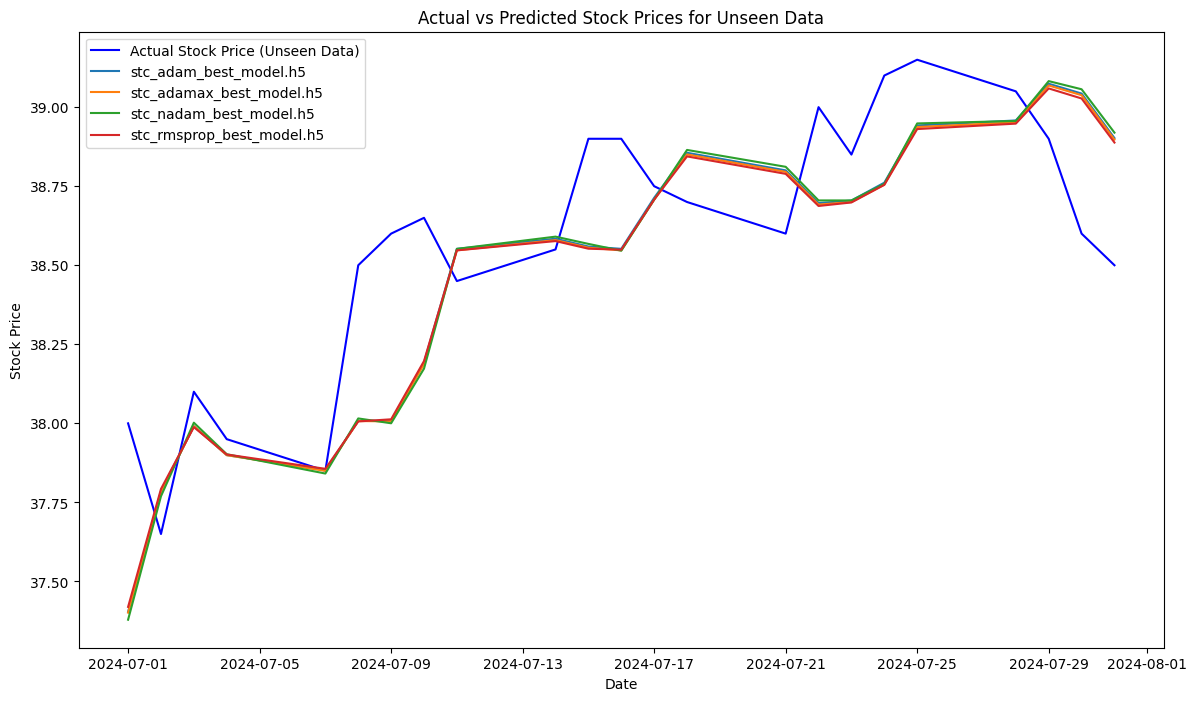

In [101]:
# Plot the results for the unseen data
plt.figure(figsize=(14, 8))
plt.plot(unseen_data['Date'][window_size:], y_unseen_inv, color='blue', label='Actual Stock Price (Unseen Data)')
for model_file, metrics in results.items():
    plt.plot(unseen_data['Date'][window_size:], metrics['y_pred_inv'], label=f'{model_file}')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Actual vs Predicted Stock Prices for Unseen Data')
plt.show()

# End.